## Loading Data

https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/MAI/DLMIA/Test_Data_p1.zip .
!cp /content/drive/MyDrive/MAI/DLMIA/Test_GroundTruth_p1.zip . 
!cp /content/drive/MyDrive/MAI/DLMIA/Training_Data_p1.zip .
!cp /content/drive/MyDrive/MAI/DLMIA/Training_GroundTruth_p1.zip . 
!cp /content/drive/MyDrive/MAI/DLMIA/Training_Data_p1_DA.zip . 
!cp /content/drive/MyDrive/MAI/DLMIA/Training_GroundTruth_p1_DA.zip .
!unzip -qq Test_Data_p1.zip
!unzip -qq Test_GroundTruth_p1.zip
!unzip -qq Training_Data_p1.zip
!unzip -qq Training_GroundTruth_p1.zip
!unzip -qq Training_Data_p1_DA.zip
!unzip -qq Training_GroundTruth_p1_DA.zip

Mounted at /content/drive


## Imports

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import random

from PIL import ImageOps


NUM_CLASES = 2


## Prepare data

In [3]:
input_dir_train = "/content/ISBI2016_ISIC_Part1_Training_Data/"
target_dir_train = "/content/ISBI2016_ISIC_Part1_Training_GroundTruth/"
input_dir_test = "/content/ISBI2016_ISIC_Part1_Test_Data/"
target_dir_test = "/content/ISBI2016_ISIC_Part1_Test_GroundTruth/"
input_dir_train_DA = "/content/Training_Data_p1_DA/"
target_dir_train_DA = "/content/Training_GroundTruth_p1_DA/"
img_size = (256, 256)
batch_size = 8

def get_paths(input_dir, target_dir):
  input_img_paths = sorted(
      [
          os.path.join(input_dir, fname)
          for fname in os.listdir(input_dir)
          if fname.endswith(".jpg")
      ]
  )
  target_img_paths = sorted(
      [
          os.path.join(target_dir, fname)
          for fname in os.listdir(target_dir)
          if fname.endswith(".png") and not fname.startswith(".")
      ]
  )

  return input_img_paths, target_img_paths

  #for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
  #    print(input_path, "|", target_path)
input_test_paths, target_test_paths = get_paths(input_dir_test, target_dir_test)
DA = True
if not DA:
    input_train_paths, target_train_paths = get_paths(input_dir_train, target_dir_train)
    total_img = int(0.8*len(input_train_paths))

else:
    input_train_paths, target_train_paths = get_paths(input_dir_train_DA, target_dir_train_DA)
    total_img = int(0.8*len(input_train_paths))

input_val_paths = input_train_paths[total_img:]
input_train_paths = input_train_paths[:total_img]
target_val_paths =  target_train_paths[total_img:]
target_train_paths = target_train_paths[:total_img]

print("Number of samples:", len(input_train_paths), len(target_train_paths))
print("Number of samples val", len(input_val_paths), len(target_val_paths))

Number of samples: 2160 2160
Number of samples val 540 540


## Data Generator


In [4]:
class DataGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            x[j] /= 255
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
            y[j] = np.uint8(y[j]/255)
        return x, y

    """def on_epoch_end(self): 
      random.seed(random.random())
      random.shuffle(self.input_img_paths)
      random.shuffle(self.target_img_paths)

    """


## Model

In [9]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((256,256), NUM_CLASES)
#model.summary()

## Defining new metrics

In [10]:
from keras import backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth
  

## Train

In [11]:
EPOCHS = 15
BATCH_SIZE = 16
train_generator = DataGenerator(BATCH_SIZE,(256,256),input_train_paths, target_train_paths)
val_generator = DataGenerator(BATCH_SIZE,(256,256), input_val_paths, target_val_paths)
test_generator = DataGenerator(BATCH_SIZE,(256,256), input_test_paths, target_test_paths)

In [12]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy", 
              metrics=["accuracy", jaccard_distance
              ])
callbacks = [
    keras.callbacks.ModelCheckpoint("rmsprop_bat16_30_epoc_DA.h5", save_best_only=True),
   # keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto', restore_best_weights=True)
]

# Train the model, doing validation at the end of each epoch.
mdl_hist = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks)


Epoch 1/15
135/135 [==============================] - 118s 836ms/step - loss: 0.8571 - accuracy: 0.7600 - jaccard_distance: 0.9876 - val_loss: 0.6617 - val_accuracy: 0.9999 - val_jaccard_distance: 0.9873
Epoch 2/15
135/135 [==============================] - 112s 813ms/step - loss: 0.4196 - accuracy: 0.7713 - jaccard_distance: 0.9876 - val_loss: 0.9624 - val_accuracy: 1.0000 - val_jaccard_distance: 0.9873
Epoch 3/15
135/135 [==============================] - 112s 822ms/step - loss: 0.3987 - accuracy: 0.7808 - jaccard_distance: 0.9876 - val_loss: 0.5547 - val_accuracy: 0.9812 - val_jaccard_distance: 0.9873
Epoch 4/15
135/135 [==============================] - 112s 828ms/step - loss: 0.3657 - accuracy: 0.7824 - jaccard_distance: 0.9876 - val_loss: 0.4198 - val_accuracy: 0.7974 - val_jaccard_distance: 0.9873
Epoch 5/15
135/135 [==============================] - 112s 830ms/step - loss: 0.3487 - accuracy: 0.7785 - jaccard_distance: 0.9876 - val_loss: 0.4267 - val_accuracy: 0.8739 - val_jacca

## Results

In [ ]:
mdl_hist.history.keys()

dict_keys(['loss', 'accuracy', 'jaccard_distance', 'val_loss', 'val_accuracy', 'val_jaccard_distance'])

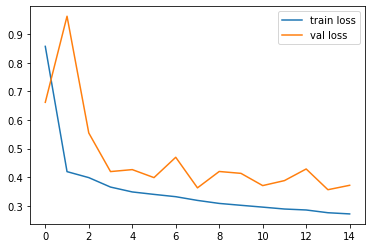

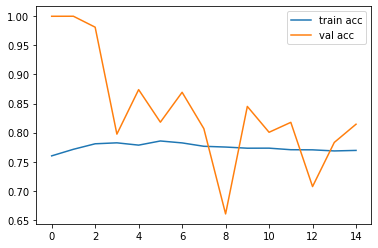

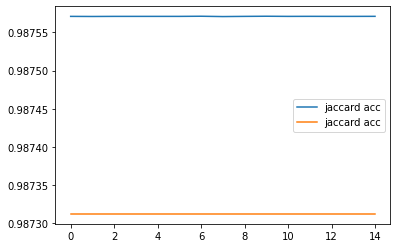

In [13]:
plt.plot(mdl_hist.history['loss'], label='train loss')
plt.plot(mdl_hist.history['val_loss'], label='val loss')
plt.legend()
plt.savefig("data_epochs_" +str(EPOCHS)+"_batchSize_"+ str(BATCH_SIZE)+'_LossVal_loss')
plt.show()
# plot the accuracy
plt.plot(mdl_hist.history['accuracy'], label='train acc')
plt.plot(mdl_hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig("data_epochs_" +str(EPOCHS)+"_batchSize_"+ str(BATCH_SIZE)+'_AccVal_acc')
#save model to disk
plt.show()

#plot de jaccard
plt.plot(mdl_hist.history['jaccard_distance'], label='jaccard acc')
plt.plot(mdl_hist.history['val_jaccard_distance'], label='jaccard acc')
plt.legend()
plt.savefig("data_epochs_" +str(EPOCHS)+"_batchSize_"+ str(BATCH_SIZE)+'val_jaccard_distance')
#save model to disk
plt.show()



In [ ]:
results = model.evaluate(test_generator, batch_size=8)
print("test loss, test acc:", results)


23/23 [==============================] - 16s 690ms/step - loss: 0.3014 - accuracy: 0.8131 - jaccard_distance: 0.9874
test loss, test acc: [0.3014349639415741, 0.8131341338157654, 0.9873762726783752]


23/23 [==============================] - 16s 682ms/step


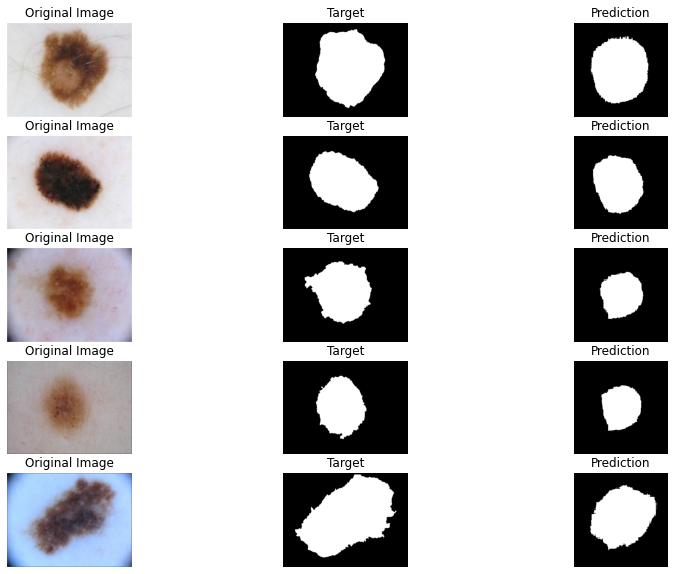

In [14]:
def mask_to_image(preds, i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = keras.preprocessing.image.array_to_img(mask)
    return img

val_preds = model.predict(test_generator)

import numpy.ma as ma

# Display results for validation image #10
inds = [0,2,4,8,10]

# Create figure and plot
fig = plt.figure(figsize=(14, 10))

nrows = len(inds)
ncols = 3

for row, i in enumerate(inds):
    base_ind = row*ncols

    # Add the original image subplot at the 1st position
    fig.add_subplot(nrows, ncols, base_ind+1)
    image = plt.imread(input_test_paths[i])
    plt.imshow(image)
    plt.axis('off')
    plt.title("Original Image")

    # Add the original target subplot at the 2nd position
    fig.add_subplot(nrows, ncols, base_ind+2)
    target = plt.imread(target_test_paths[i])
    plt.imshow(target, cmap="gray")
    plt.axis('off')
    plt.title("Target")

    # Add the predicted target subplot at the 3rd position
    fig.add_subplot(nrows, ncols, base_ind+3)
    pred = mask_to_image(val_preds, i)
    plt.imshow(pred, cmap="gray")
    plt.axis('off')
    plt.title("Prediction")

plt.show()

In [15]:
!cp /content/rmsprop_bat16_30_epoc_DA.h5 /content/drive/MyDrive/MAI/DLMIA/rmsprop_bat16_30_epoc_DA.h5